In [1]:
import pulp
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import docplex
distance_matrix = pd.read_csv('dataset/Distance_Matrix.csv').drop('Unnamed: 0', axis=1)
biomass_history = pd.read_csv('dataset/Biomass_History.csv')


![Alt text](image.png)

### Detalhes:

- *Variáveis de Decisão*: As variáveis `x`, `y`, `depot`, e `refinery` representam as decisões de alocação e seleção.
- *Função Objetivo*: A função objetivo combina o custo de transporte e a incompatibilidade da previsão de biomassa.
- *Restrições*: As restrições garantem que cada local de colheita seja atribuído a um depósito, cada depósito a uma refinaria, e outras restrições específicas do problema.

Este código é um esboço geral e pode precisar de ajustes e detalhamento adicionais com base nos dados e requisitos específicos do problema.

In [2]:
year = '2011'
B = biomass_history[year].to_numpy()
D = distance_matrix.to_numpy()
C = 20_000

num_warehouses = 10
num_harvesting_sites = 100

B = B[:num_harvesting_sites]
D = D[:num_harvesting_sites, :num_harvesting_sites]

In [3]:
def print_matrix(matrix):
    print(pd.DataFrame(matrix).to_string(index=True, header=True))

In [4]:
costs = B.reshape(-1, 1)*D
print_matrix(costs[:5, :5])

             0            1            2            3            4
0     0.000000   100.896816   181.412775   338.093773   402.464503
1   324.825828     0.000000   259.211976   825.536523  1032.770771
2  1352.350217   600.210071     0.000000  1479.508438  1959.363128
3  3081.126338  2336.875275  1808.708052     0.000000   956.463562
4   877.102375   699.122936   572.817565   228.727720     0.000000


In [5]:
# create a function that optimize the p-median problem for a subset of harvesting sites
def create_problem(cost_matrix: np.ndarray, biomass_array: np.ndarray, n_depots:int, capacity: int, year: str):
    n_harvesting_sites = len(biomass_array)
    depots_locations = [j for j in range(n_harvesting_sites)]
    harvesting_sites = [i for i in range(n_harvesting_sites)]
    
    x = pulp.LpVariable.dicts('x%s_y%s', (harvesting_sites, depots_locations), cat=pulp.LpBinary)
    y = pulp.LpVariable.dicts('y%s', depots_locations, cat=pulp.LpBinary)

    prob = pulp.LpProblem("p-median", pulp.LpMinimize)
    
    cost_of_transportation = pulp.lpSum([(x[i][j] * cost_matrix[i][j] for j in depots_locations) for i in harvesting_sites])
    cost_of_underutilization = pulp.lpSum([(C - pulp.lpSum([x[i][j]*B[i] for i in harvesting_sites])) for j in depots_locations])
    a = 0.001
    b = 1
    prob += a * cost_of_transportation + b * cost_of_underutilization

        # Constraint 1: Number of warehouses must be less or equal to the maximum number of warehouses
    prob += (
        pulp.lpSum([y[j] for j in depots_locations]) <= n_depots, 
        "Maximum_number_of_warehouses"
        )

    # Constraint 2: Each harvesting site must be assigned to exactly one warehouse
    for i in harvesting_sites:
        prob += (
            pulp.lpSum([x[i][j] for j in depots_locations]) == 1,
            f"Harvesting_site_{i}_must_be_assigned_to_exactly_one_warehouse"
        )

    # Constraint 3: If a harvesting site is assigned to a warehouse, the warehouse must be selected
    for i in harvesting_sites:
        for j in depots_locations:
            prob += (
                x[i][j] <= y[j],
                f"Harvesting_site_{i}_must_be_assigned_to_warehouse_{j}_only_if_warehouse_{j}_is_selected"
            )

    # Constraint 4: Limit the capacity of each warehouse
    for j in depots_locations:
        prob += (
            pulp.lpSum([x[i][j] * B[i] for i in harvesting_sites]) <= capacity,
            f"Limit_the_capacity_of_warehouse_{j}"
        )

    return prob


prob = create_problem(costs, B, num_warehouses, C, year)
len(prob.variablesDict())

10100

In [6]:
prob.solve(pulp.CPLEX_PY(mip=True, msg=True))

Version identifier: 22.1.1.0 | 2022-11-27 | 9160aff4d
CPXPARAM_Read_DataCheck                          1
Found incumbent of value -7445.668349 after 0.02 sec. (1.14 ticks)
Tried aggregator 1 time.
MIP Presolve eliminated 100 rows and 0 columns.
Reduced MIP has 10101 rows, 10100 columns, and 30100 nonzeros.
Reduced MIP has 10100 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.06 sec. (49.26 ticks)
Probing time = 0.02 sec. (5.21 ticks)
Tried aggregator 1 time.
Detecting symmetries...
Reduced MIP has 10101 rows, 10100 columns, and 30100 nonzeros.
Reduced MIP has 10100 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.05 sec. (51.53 ticks)
Probing time = 0.01 sec. (5.21 ticks)
Clique table members: 10100.
MIP emphasis: balance optimality and feasibility.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 6 threads.
Root relaxation solution time = 0.02 sec. (13.82 ticks)

        Nodes                                         Cuts/


1

In [7]:
# print the status of the solution
print("Status:", pulp.LpStatus[prob.status])

if pulp.LpStatus[prob.status] == "Optimal":
    print("Objective = ", pulp.value(prob.objective))
    print("Variables:")
    for v in prob.variables():
        print(v.name, "=", v.varValue)
else:
    print("No optimal solution found.")

Status: Optimal
Objective =  1991485.3196716702
Variables:
x0_y0 = 0.0
x0_y1 = 0.0
x0_y10 = 0.0
x0_y11 = 0.0
x0_y12 = 0.0
x0_y13 = 0.0
x0_y14 = 0.0
x0_y15 = 0.0
x0_y16 = 0.0
x0_y17 = 0.0
x0_y18 = 0.0
x0_y19 = 0.0
x0_y2 = 0.0
x0_y20 = 0.0
x0_y21 = 0.0
x0_y22 = 0.0
x0_y23 = 0.0
x0_y24 = 0.0
x0_y25 = 0.0
x0_y26 = 0.0
x0_y27 = 0.0
x0_y28 = 0.0
x0_y29 = 0.0
x0_y3 = 0.0
x0_y30 = 0.0
x0_y31 = 0.0
x0_y32 = 0.0
x0_y33 = 0.0
x0_y34 = 0.0
x0_y35 = 0.0
x0_y36 = 0.0
x0_y37 = 0.0
x0_y38 = 0.0
x0_y39 = 0.0
x0_y4 = 0.0
x0_y40 = 0.0
x0_y41 = 0.0
x0_y42 = 0.0
x0_y43 = 0.0
x0_y44 = 0.0
x0_y45 = 0.0
x0_y46 = 0.0
x0_y47 = 0.0
x0_y48 = 0.0
x0_y49 = 0.0
x0_y5 = 0.0
x0_y50 = 0.0
x0_y51 = 0.0
x0_y52 = 0.0
x0_y53 = 0.0
x0_y54 = 0.0
x0_y55 = 0.0
x0_y56 = 0.0
x0_y57 = 0.0
x0_y58 = 0.0
x0_y59 = 0.0
x0_y6 = 0.0
x0_y60 = 0.0
x0_y61 = 0.0
x0_y62 = 0.0
x0_y63 = 0.0
x0_y64 = 0.0
x0_y65 = 0.0
x0_y66 = 0.0
x0_y67 = 0.0
x0_y68 = 0.0
x0_y69 = 0.0
x0_y7 = 0.0
x0_y70 = 0.0
x0_y71 = 0.0
x0_y72 = 0.0
x0_y73 = 0.0
x0_y74 = 0.0


In [8]:
hs=[]
ws=[]
loc_selection=[]
for v in prob.variables():
    if v.name.startswith('x'):
        splitted = v.name.split('_')
        i = int(splitted[0][1:])
        j = int(splitted[1][1:])
        hs.append(i)
        ws.append(j)
        loc_selection.append(v.varValue)

solution = pd.DataFrame({'harvesting_site': hs, 'warehouse': ws, 'selected': loc_selection})
solution

,harvesting_site,warehouse,selected
0,0,0,0.0
1,0,1,0.0
2,0,10,0.0
3,0,11,0.0
4,0,12,0.0
...,...,...,...
9995,9,95,0.0
9996,9,96,0.0
9997,9,97,0.0
9998,9,98,0.0


In [9]:
solution[f'{year}_biomass'] = solution['harvesting_site'].apply(lambda x: B[x])
solution

,harvesting_site,warehouse,selected,2011_biomass
0,0,0,0.0,8.868568
1,0,1,0.0,8.868568
2,0,10,0.0,8.868568
3,0,11,0.0,8.868568
4,0,12,0.0,8.868568
...,...,...,...,...
9995,9,95,0.0,68.375999
9996,9,96,0.0,68.375999
9997,9,97,0.0,68.375999
9998,9,98,0.0,68.375999


In [10]:
selected_ones = solution[solution['selected'] == 1]
biomass_by_warehouse = selected_ones.groupby('warehouse').sum()[f'{year}_biomass']
biomass_by_warehouse

warehouse
9      127.252861
24     164.727707
36      94.076744
39     112.800453
70     194.977951
81     123.177155
99    7697.667458
Name: 2011_biomass, dtype: float64

In [11]:
selected_ones.apply(lambda x: D[int(x['harvesting_site'])][int(x['warehouse'])] * x[f'{year}_biomass'], axis=1).sum()

482359.4278244309

c:\Users\mathe\miniconda3\envs\wastetoenergy\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\mathe\miniconda3\envs\wastetoenergy\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\mathe\miniconda3\envs\wastetoenergy\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


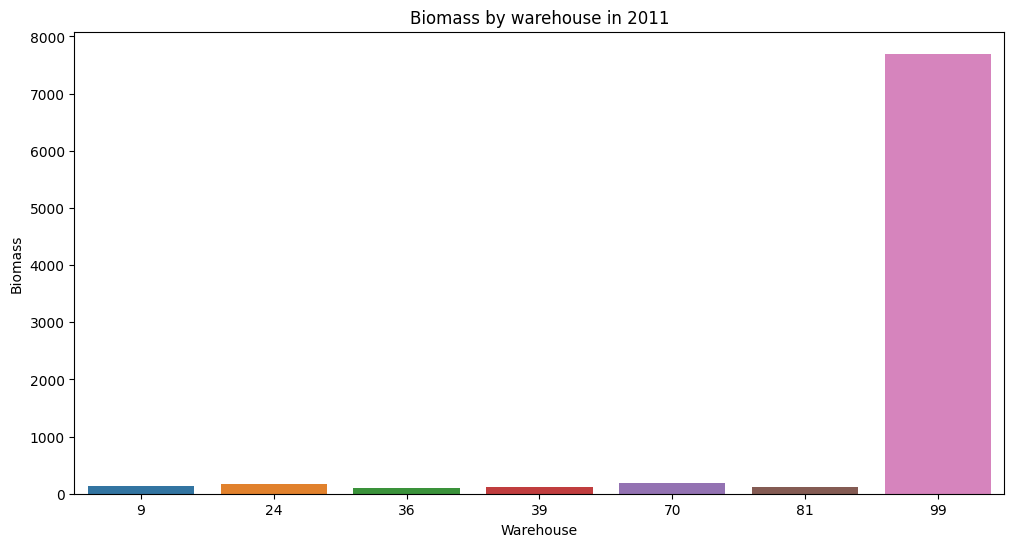

In [12]:
# plot the biomass by warehouse
plt.figure(figsize=(12, 6))
sns.barplot(x=biomass_by_warehouse.index, y=biomass_by_warehouse.values)
plt.title(f'Biomass by warehouse in {year}')
plt.xlabel('Warehouse')
plt.ylabel('Biomass')
plt.show()


In [13]:
solution['HS_Longitude']= solution['harvesting_site'].apply(lambda idx: biomass_history['Longitude'][int(idx)])
solution['HS_Latitude']= solution['harvesting_site'].apply(lambda idx: biomass_history['Latitude'][int(idx)])
solution['W_Longitude']= solution['warehouse'].apply(lambda idx: biomass_history['Longitude'][int(idx)])
solution['W_Latitude']= solution['warehouse'].apply(lambda idx: biomass_history['Latitude'][int(idx)])
solution

,harvesting_site,warehouse,selected,2011_biomass,HS_Longitude,HS_Latitude,W_Longitude,W_Latitude
0,0,0,0.0,8.868568,71.33144,24.66818,71.33144,24.66818
1,0,1,0.0,8.868568,71.33144,24.66818,71.41106,24.66818
2,0,10,0.0,8.868568,71.33144,24.66818,72.12769,24.66818
3,0,11,0.0,8.868568,71.33144,24.66818,72.20732,24.66818
4,0,12,0.0,8.868568,71.33144,24.66818,72.28694,24.66818
...,...,...,...,...,...,...,...,...
9995,9,95,0.0,68.375999,72.04807,24.66818,71.57031,24.26518
9996,9,96,0.0,68.375999,72.04807,24.66818,71.64994,24.26518
9997,9,97,0.0,68.375999,72.04807,24.66818,71.72956,24.26518
9998,9,98,0.0,68.375999,72.04807,24.66818,71.80919,24.26518


c:\Users\mathe\miniconda3\envs\wastetoenergy\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\mathe\miniconda3\envs\wastetoenergy\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\mathe\miniconda3\envs\wastetoenergy\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\mathe\miniconda3\envs\wastetoenergy\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future v

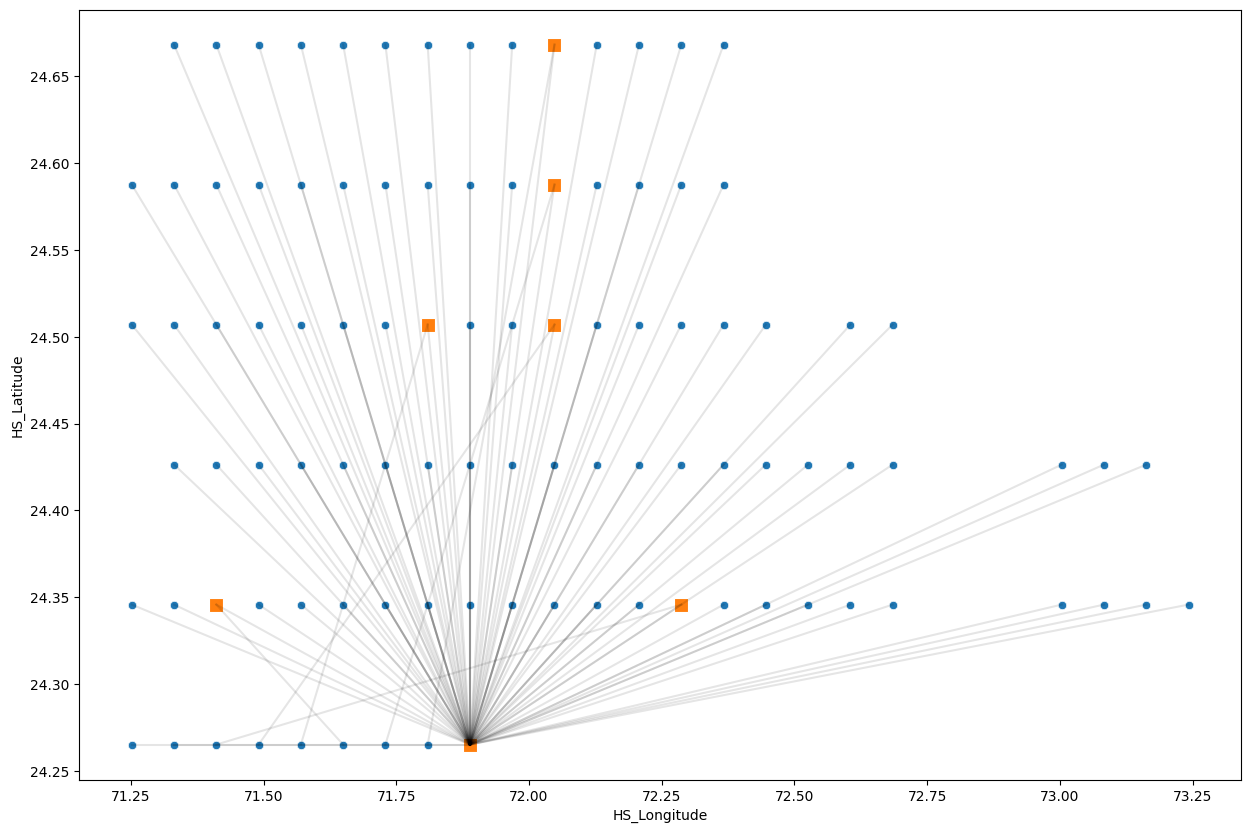

In [14]:
# Plotting the solution with seaborn
plt.figure(figsize=(15, 10))
sns.scatterplot(data=solution, x='HS_Longitude', y='HS_Latitude')
sns.scatterplot(data=solution[solution.selected==1], x='W_Longitude', y='W_Latitude', marker='s', s=100)

# plot the connections between harvesting sites and warehouses
for i in range(len(solution)):
    if solution.iloc[i]['selected'] == 1:
        plt.plot([solution.iloc[i]['HS_Longitude'], solution.iloc[i]['W_Longitude']], [solution.iloc[i]['HS_Latitude'], solution.iloc[i]['W_Latitude']], color='black', alpha=0.1)


plt.show()
